In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

c:\Users\rsore\anaconda3\envs\GEARS\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\rsore\anaconda3\envs\GEARS\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
c:\Users\rsore\anaconda3\envs\GEARS\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
c:\Users\rsore\anaconda3\envs\GEARS\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
c:\Users\rsore\anaconda3\envs\GEARS\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import

In [2]:
perturb_adata = sc.read_h5ad('data/norman/perturb_processed.h5ad')

In [3]:
import requests
from collections import deque, defaultdict

BIOGRID_API_KEY = "c96e98ea2b2419dd9a3d53b0b6b6b7c6"

def resolve_to_official_symbol(gene):
    """Resolve a gene name to its official symbol using MyGene.info."""
    url = "https://mygene.info/v3/query"
    params = {
        "q": gene,
        "species": "human",
        "fields": "symbol",
        "limit": 1
    }
    try:
        r = requests.get(url, params=params, timeout=5)
        hits = r.json().get("hits", [])
        return hits[0]["symbol"].upper() if hits else gene.upper()
    except Exception as e:
        print(f"Error resolving {gene}: {e}")
        return gene.upper()
    
# Cache for API results to avoid redundant queries
interaction_cache = {}
def get_top_interactors(gene, top_n=None):
    gene_resolved = resolve_to_official_symbol(gene)
    
    if top_n is None and gene_resolved in interaction_cache:
        return interaction_cache[gene_resolved]

    url = "https://webservice.thebiogrid.org/interactions/"
    params = {
        "accesskey": BIOGRID_API_KEY,
        "searchNames": "true",
        "geneList": gene_resolved,
        "includeInteractors": "true",
        "format": "json",
        "includeHeader": "false",
        "taxId": "9606",
        "start": 0,
        "max": 10000
    }

    try:
        resp = requests.get(url, params=params, timeout=10)
        data = resp.json()
    except Exception as e:
        print(f"Error querying BioGRID for {gene}: {e}")
        interaction_cache[gene_resolved] = []
        return []

    if not isinstance(data, dict):
        interaction_cache[gene_resolved] = []
        return []

    interaction_counts = defaultdict(int)
    for interaction in data.values():
        a = interaction.get('OFFICIAL_SYMBOL_A', '').upper()
        b = interaction.get('OFFICIAL_SYMBOL_B', '').upper()
        partner = None
        if a == gene_resolved:
            partner = b
        elif b == gene_resolved:
            partner = a
        if partner:
            interaction_counts[partner] += 1

    sorted_partners = sorted(interaction_counts.items(), key=lambda x: -x[1])
    top_partners = [gene for gene, count in sorted_partners[:top_n]] if top_n else [gene for gene, count in sorted_partners]

    if top_n is None:
        interaction_cache[gene_resolved] = top_partners

    return top_partners


In [ ]:
import networkx as nx

def build_gene_interaction_graph(gene_list, n=10):
    """
    Build a graph where each gene in `gene_list` is connected to its top `n` BioGRID interactors.
    Removes circular (self-loop) connections.
    """
    G = nx.Graph()

    for i, gene in enumerate(gene_list):
        print(f"Processing gene {i+1}/{len(gene_list)}: {gene}", end='\r')
        head_gene = resolve_to_official_symbol(gene)
        top_interactors = get_top_interactors(head_gene, top_n=n)

        G.add_node(head_gene)

        for partner in top_interactors:
            partner = partner.upper()
            if partner != head_gene:
                G.add_node(partner)
                G.add_edge(head_gene, partner)

    return G

In [5]:
gene_name_map = perturb_adata.var['gene_name']
de_dict = perturb_adata.uns['top_non_dropout_de_20']

max_conditions = 1000

In [13]:
# Get all unique genes from the DE conditions
unique_genes = set()
for condition in list(de_dict.keys())[:max_conditions]:
    name1, name2 = condition.split('_')[1].split('+')
    unique_genes.update([name1, name2])

# Build the graph
G = build_gene_interaction_graph(unique_genes, n=5)

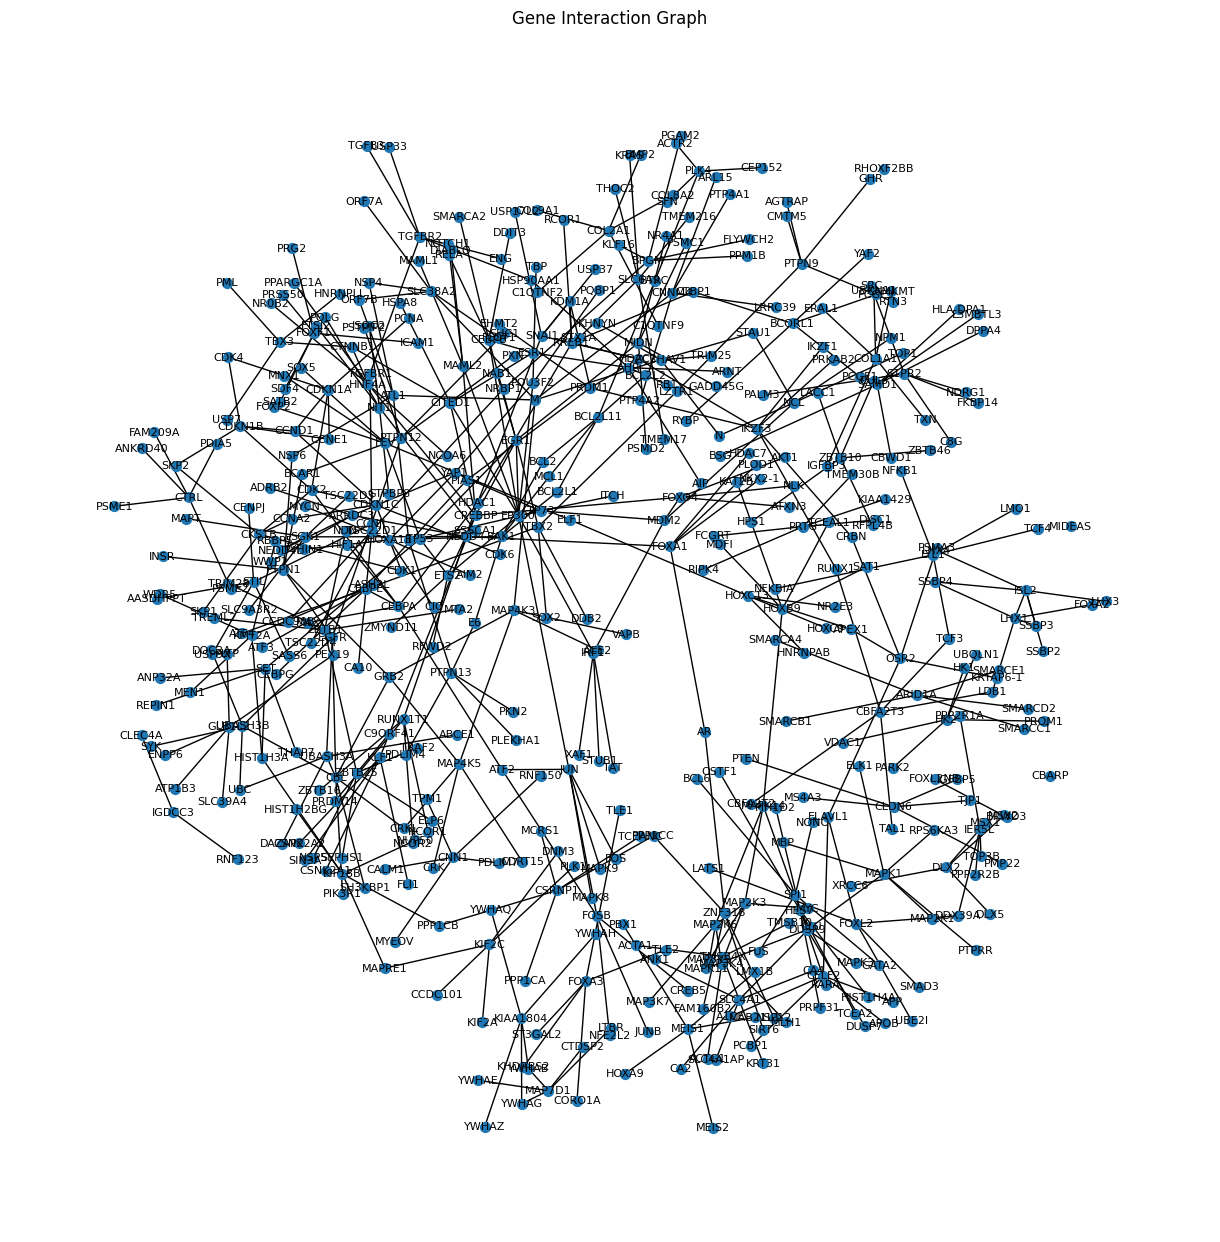

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Gene Interaction Graph")
plt.show()


In [ ]:
# save interaction graph because to load into gears, we need to filter to nodes in pert_list 

import pickle
with open('BioGRID_graph.pkl', 'wb') as f:
    pickle.dump(G, f)